<a href="https://colab.research.google.com/github/Pankaj1357/HC18-Grand-Challenge/blob/master/HC18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd

# **Mask Generation**
Done only once and replaced that  annotation with masks permanently
Did not changed the annotation file name though

## **Warning!!!**
Do not run below cells as task is already completed

In [2]:
train_pixel_file = pd.read_csv('training_set_pixel_size_and_HC.csv')
train_pixel_file.head()
# This Dataframe will be used to extract image names hence by doing image_name + '_Annotation' we will get annotation names

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [3]:
# This function takes annotation and spits out corresponding mask
def masking(image):
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours,useless = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    return cv2.ellipse(image, ellipse, (255,255,255), -1)

training_set/000_HC_Annotation.png
training_set/001_HC_Annotation.png
training_set/002_HC_Annotation.png
training_set/003_HC_Annotation.png
training_set/004_HC_Annotation.png
training_set/005_HC_Annotation.png
training_set/006_HC_Annotation.png


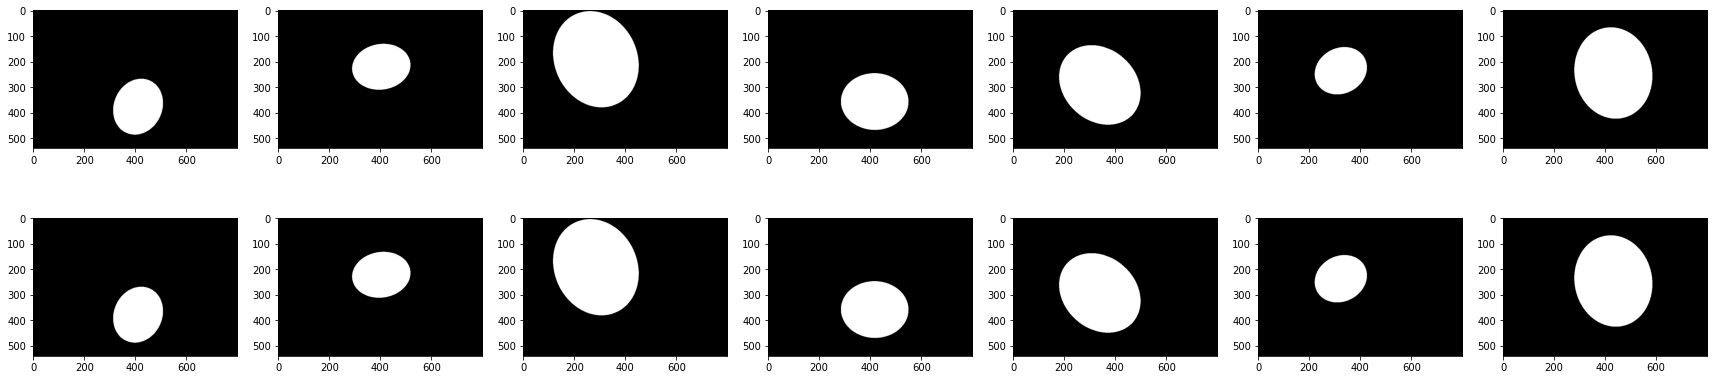

In [4]:
# to check if our masking function is working correctly
fig = plt.figure(figsize = (30,7))
for index in range(7):
  file_path = os.path.join('training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
  print(file_path)
  ax = fig.add_subplot(2, 7, index+1)             ## annoted plot
  plt.imshow(cv2.imread(file_path))
    
  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(masking(cv2.imread(file_path)))        ## mask plot

In [5]:
# Here we loop through training set and  take annotations one by one and replace them with corresponding masks
fig = plt.figure(figsize = (30,7))
for index in range(len(train_pixel_file)):
    file_path = os.path.join('training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
    image = cv2.imread(file_path)
    mask = masking(image)
    cv2.imwrite(file_path, mask)

<Figure size 2160x504 with 0 Axes>

## **Warning!!!**
**Done with mask generation. Don't run above cells ever again**

### **Do all the imports in below cell**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from skimage import io, color
from PIL import Image
import cv2

import os
import random

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [7]:
validation_set_size = 0.20            # fraction of dataset used for validation which will be splited randomly

In [8]:
# our dataset class
class HC18(Dataset):
  #""" train and validation dataset class"""
    def __init__(self, root_dir, train = True, transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'training_set_pixel_size_and_HC.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        
        # lets split the dataset in train and validation
        self.train_data, self.validation_data = train_test_split(self.pixel_file, test_size = validation_set_size, random_state = 5)
        
    def __len__(self):
        
        if self.train:
          length = len(self.train_data)
        else:
          length = len(self.validation_data)
        return length
    
    def __getitem__(self, index):
      
        if self.train:
          imx_name = os.path.join(self.root_dir, 'training_set', self.train_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'training_set',self.train_data.iloc[index, 0].replace('.png','_Annotation.png'))

        else:
          imx_name = os.path.join(self.root_dir, 'training_set', self.validation_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'training_set',self.validation_data.iloc[index, 0].replace('.png','_Annotation.png'))
        
        
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')
        
        ## tried some data augmentation techniques
        if self.train:
          # Random horizontal flipping
          if random.random() > 0.5:
              imx = TF.hflip(imx)
              imy = TF.hflip(imy)

          # Random vertical flipping
          if random.random() > 0.5:
              imx = TF.vflip(imx)
              imy = TF.vflip(imy)


          # Random rotation
          if random.random() > 0.8:
            angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
            imx = TF.rotate(imx, angle)
            imy = TF.rotate(imy, angle)
        
        
        
        
        
        
        if self.transformX :
            imx = self.transformX(imx)
            imy = self.transformY(imy)
        
        sample = {'image': imx, 'annotation': imy}
        return sample

In [9]:
# our datasets
tx_X = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])
tx_Y = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),  ################ no need to normalize the maskk
                             # transforms.Normalize((0.5,), (0.5,))
                              ])
train_data = HC18('', train = True, transformX = tx_X, transformY = tx_Y)
validation_data = HC18('', train = False, transformX = tx_X, transformY = tx_Y )

In [10]:
# our dataloaders
train_loader = DataLoader(dataset = train_data, batch_size = 2, shuffle = True, num_workers = 2 )
validation_loader = DataLoader(dataset = validation_data, batch_size = 2, shuffle = True, num_workers = 2)

In [11]:
# this function will return numpy array from the transformed tensors which were
# obtained from our train_loader. Just to plot them and see if they are intact :) ha ha
def im_converterX(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # unnormalizing the image # this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

In [12]:
# this function will return numpy array from the transformed tensors which were
# obtained from our train_loader. Just to plot them and see if they are intact :) ha ha
def im_converterY(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    image = image * np.array((1, 1, 1)) # unnormalizing the image  not needed# this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

0 torch.Size([2, 1, 572, 572]) torch.Size([2, 1, 572, 572])


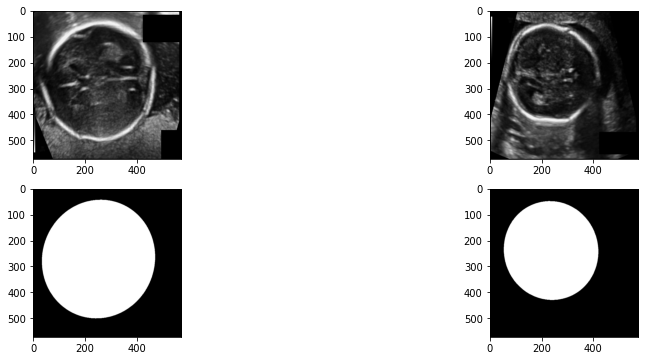

In [43]:
## Here we loop through our train_loader and see the images
## Looks good
fig = plt.figure(figsize = (15,6))
for ith_batch, sample_batched in enumerate(train_loader):
    print(ith_batch, sample_batched['image'].size(), sample_batched['annotation'].size())
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(sample_batched['image'][index]))
        ax = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(sample_batched['annotation'][index]))
    break

In [14]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.7),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.77),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear: #upsampling will not be learnable
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:  # it will be learnable here
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
        
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x
    
    
class attention_gate(nn.Module):
    def __init__(self, in_ch_g,in_ch_x,out_ch):
        super(attention_gate, self).__init__()
        self.conv = nn.Conv2d(in_ch_g,in_ch_x, 1)
        self.conv_att = nn.Conv2d(in_ch_x,in_ch_x,1)
#         self.resampler = nn.Conv2d()

#     x orignal, g new
    def forward(self,g,x):
        orig_x = x        
#         upconv then downsample x
#         print(f'g = {g.shape}')
#         print(f'x = {x.shape}')
        g = self.conv(g)
        
        g = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)(g)
        diffY = x.size()[2] - g.size()[2]
        diffX = x.size()[3] - g.size()[3]

        g = F.pad(g, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
    
        a = g + x
        a = nn.ReLU()(a)
        a = nn.Sigmoid()(a)
        a = a * orig_x
        a = self.conv_att(a)
#         a = torch.reshape(a,shape)
        return a

In [15]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 16)
        self.down1 = down(16, 32)
        self.down2 = down(32, 64)
        self.down3 = down(64, 64)
#         self.down4 = down(512, 512)
        self.up1 = up(128, 32, bilinear = False) # upsampling weights are made learnable
        self.up2 = up(64, 16, bilinear = False)
        self.up3 = up(32, 8, bilinear = False)
#         self.up4 = up(32, 8, bilinear = False)
       
        self.dropout = torch.nn.Dropout2d(0.1)
        self.dropout2 = torch.nn.Dropout2d(0.2)
        self.ag3 = attention_gate(64,64,64)
        self.ag2 = attention_gate(32,32,32)
        self.ag1 = attention_gate(16,16,16)
        self.bot_conv1 = nn.Conv2d(64,8,3)
        self.bot_conv2 = nn.Conv2d(32,8,3)
        self.bot_conv3 = nn.Conv2d(16,8,3)
        self.bot_conv4 = nn.Conv2d(8,8,3)
        self.upsample1 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.upsample2 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.outc = outconv(32, n_classes)
        
    def forward(self, x):
        x = x.float()
        x1 = self.inc(x)
        x1 = self.dropout(x1)
        x2 = self.down1(x1)
        x2 = self.dropout(x2)
        x3 = self.down2(x2)
        x3 = self.dropout(x3)
        x4 = self.down3(x3)
        x4 = self.dropout(x4)
        ag3 = self.ag3(x4,x3)
        y1 = self.up1(x4, ag3)
#         print(y1.shape)
#         print(x2.shape)
        ag2 = self.ag2(y1,x2)
        y2 = self.up2(y1,ag2)
        ag1 = self.ag1(y2,x1)
        y3 = self.up3(y2,ag1)
        #x = self.dropout(x) #
#         y3 = self.outc(y3)
#         y3 = torch.sigmoid(y3)
#         print(x4.shape) 
        
        # Bottom
        
        x4 =  self.bot_conv1(x4)
        x4 =  F.pad(x4,(1,1,1,1))
        y1 =  self.bot_conv2(y1)
        y1 = F.pad(y1,(1,1,1,1))
        y2 =  self.bot_conv3(y2)
        y2 = F.pad(y2,(1,1,1,1))
        y3 =  self.bot_conv4(y3)
        y3 = F.pad(y3,(1,1,1,1))
       
        x4 = self.upsample1(x4)
        x4 = F.pad(x4,(2,2,2,2))
        y1 = self.upsample2(y1)
        y2 = self.upsample3(y2)
        
        final = torch.cat([x4,y1,y2,y3], dim=1)
        final = self.outc(final)
        return torch.sigmoid(final)
      
      
      
      
      
      
model = UNet(1, 1)
model.to('cuda')
print("Model Loaded to GPU")

Model Loaded to GPU


In [16]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0077)

In [17]:
# calculates similarity index between predicted and actual segmentation
def dice_index(y_pred, y_actual):
    smooth = 0.000001
    size_of_batch = y_pred.size(0)
    
    p1 = y_pred.view(size_of_batch, -1)
    p2 = y_actual.view(size_of_batch, -1)
    
    intersection = (p1 * p2).sum()
    
    dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)
    #dice.requires_grad = True
    
    return dice

In [18]:
# calculate dice loss which will be later used in loss function calculation
def dice_loss(y_predict, y_train): ## to add in bce looss
  
  dice_loss = 1 -(dice_index(y_predict, y_train))
  
  return dice_loss
  

In [19]:
epochs = 250


train_running_loss_history = []
validation_running_loss_history =[]

for e in range(epochs):
  train_running_loss = 0.0
  validation_running_loss = 0.0
  
  model.train()
  
  for ith_batch, sample_batched in enumerate(train_loader):
    X_train = sample_batched['image'].to('cuda')
    y_train = sample_batched['annotation'].to('cuda')
    
    #X_train.requires_grad = True
    #y_train.requires_grad = True

    #print(ith_batch) #, X_train.size(), y_train.size())

    optimizer.zero_grad()
    y_pred = model(X_train)
   # out = (y_pred + 0.5).int().float()
    
    loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)
    #loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if ith_batch % 50 == 0:
      print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
      
    train_running_loss += loss.item()
    
    
    
    
  else:
    with torch.no_grad():
      
      model.eval()
      
      for ith_batch, sample_batched in enumerate(validation_loader):
          X_val = sample_batched['image'].to('cuda')
          y_val = sample_batched['annotation'].to('cuda')
          
          
          
          y_out = model(X_val)
          out_val = (y_out + 0.5).int().float()
          
          val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)
          
          #val_loss = criterion(y_out, y_val)
          
          validation_running_loss += val_loss.item()
      print("================================================================================")
      print("Epoch {} completed".format(e + 1))
      
      train_epoch_loss = train_running_loss / len(train_loader)
      validation_epoch_loss = validation_running_loss / len(validation_loader)
      
      print("Average train loss is {}: ".format(train_epoch_loss))
      print("Average validation loss is {}".format(validation_epoch_loss))
      print("================================================================================")
      train_running_loss_history.append(train_epoch_loss)
      validation_running_loss_history.append(validation_epoch_loss)
  
  torch.cuda.empty_cache()
      #print(y_pred.shape)

    #y_pred = y_pred.to('cpu')
    #X_train = X_train.to('cpu')

    #del y_train
    #torch.cuda.empty_cache()
    #if ith_batch ==100:
    #break
  #for index in range(2):
  #         ax = gig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
   #         plt.imshow(im_converter(X_train[index]))
    #        ax = gig.add_subplot(2, 2, index + 3)
     #       plt.imshow(im_converter(y_pred[index]))
  
torch.save(model,"Models/MFP-more-dropouts-250.pt")    

Epoch:  1 Batch:  0 Current Loss:  0.6355592012405396
Epoch:  1 Batch:  50 Current Loss:  0.5347722172737122
Epoch:  1 Batch:  100 Current Loss:  0.5161713361740112
Epoch:  1 Batch:  150 Current Loss:  0.5278481245040894
Epoch:  1 Batch:  200 Current Loss:  0.6088793277740479
Epoch:  1 Batch:  250 Current Loss:  0.49585428833961487
Epoch:  1 Batch:  300 Current Loss:  0.5243015289306641
Epoch:  1 Batch:  350 Current Loss:  0.4223155975341797
Epoch 1 completed
Average train loss is 0.5153120487928391: 
Average validation loss is 0.47617888301610944
Epoch:  2 Batch:  0 Current Loss:  0.47210055589675903
Epoch:  2 Batch:  50 Current Loss:  0.587989091873169
Epoch:  2 Batch:  100 Current Loss:  0.39872971177101135
Epoch:  2 Batch:  150 Current Loss:  0.40339213609695435
Epoch:  2 Batch:  200 Current Loss:  0.3170691728591919
Epoch:  2 Batch:  250 Current Loss:  0.4280779957771301
Epoch:  2 Batch:  300 Current Loss:  0.43005356192588806
Epoch:  2 Batch:  350 Current Loss:  0.466913044452667

Epoch:  12 Batch:  250 Current Loss:  0.1899411380290985
Epoch:  12 Batch:  300 Current Loss:  0.26693791151046753
Epoch:  12 Batch:  350 Current Loss:  0.3471577763557434
Epoch 12 completed
Average train loss is 0.28860029481351374: 
Average validation loss is 0.3079529829323292
Epoch:  13 Batch:  0 Current Loss:  0.23191478848457336
Epoch:  13 Batch:  50 Current Loss:  0.38854384422302246
Epoch:  13 Batch:  100 Current Loss:  0.2117863893508911
Epoch:  13 Batch:  150 Current Loss:  0.3028145730495453
Epoch:  13 Batch:  200 Current Loss:  0.5464959144592285
Epoch:  13 Batch:  250 Current Loss:  0.23269593715667725
Epoch:  13 Batch:  300 Current Loss:  0.4055079519748688
Epoch:  13 Batch:  350 Current Loss:  0.19963029026985168
Epoch 13 completed
Average train loss is 0.27423659529536965: 
Average validation loss is 0.30786794796586037
Epoch:  14 Batch:  0 Current Loss:  0.41470932960510254
Epoch:  14 Batch:  50 Current Loss:  0.3687151074409485
Epoch:  14 Batch:  100 Current Loss:  0.

Epoch:  24 Batch:  0 Current Loss:  0.1504260152578354
Epoch:  24 Batch:  50 Current Loss:  0.1620958000421524
Epoch:  24 Batch:  100 Current Loss:  0.24685946106910706
Epoch:  24 Batch:  150 Current Loss:  0.23221515119075775
Epoch:  24 Batch:  200 Current Loss:  0.15969672799110413
Epoch:  24 Batch:  250 Current Loss:  0.1904815435409546
Epoch:  24 Batch:  300 Current Loss:  0.19114650785923004
Epoch:  24 Batch:  350 Current Loss:  0.29435351490974426
Epoch 24 completed
Average train loss is 0.2153198079392314: 
Average validation loss is 0.19692723609507085
Epoch:  25 Batch:  0 Current Loss:  0.15372543036937714
Epoch:  25 Batch:  50 Current Loss:  0.23486679792404175
Epoch:  25 Batch:  100 Current Loss:  0.18595652282238007
Epoch:  25 Batch:  150 Current Loss:  0.17402595281600952
Epoch:  25 Batch:  200 Current Loss:  0.1555178165435791
Epoch:  25 Batch:  250 Current Loss:  0.3113640546798706
Epoch:  25 Batch:  300 Current Loss:  0.20466424524784088
Epoch:  25 Batch:  350 Current L

Epoch:  35 Batch:  150 Current Loss:  0.0998542457818985
Epoch:  35 Batch:  200 Current Loss:  0.1678922325372696
Epoch:  35 Batch:  250 Current Loss:  0.18724991381168365
Epoch:  35 Batch:  300 Current Loss:  0.08426522463560104
Epoch:  35 Batch:  350 Current Loss:  0.11369407176971436
Epoch 35 completed
Average train loss is 0.15982402086257935: 
Average validation loss is 0.2883040500432253
Epoch:  36 Batch:  0 Current Loss:  0.13112106919288635
Epoch:  36 Batch:  50 Current Loss:  0.09851089119911194
Epoch:  36 Batch:  100 Current Loss:  0.12957297265529633
Epoch:  36 Batch:  150 Current Loss:  0.23204141855239868
Epoch:  36 Batch:  200 Current Loss:  0.13439404964447021
Epoch:  36 Batch:  250 Current Loss:  0.07932254672050476
Epoch:  36 Batch:  300 Current Loss:  0.135491281747818
Epoch:  36 Batch:  350 Current Loss:  0.39150846004486084
Epoch 36 completed
Average train loss is 0.1593831701669842: 
Average validation loss is 0.13892501156777143
Epoch:  37 Batch:  0 Current Loss: 

Epoch:  46 Batch:  300 Current Loss:  0.22200480103492737
Epoch:  46 Batch:  350 Current Loss:  0.113370381295681
Epoch 46 completed
Average train loss is 0.1410668520256877: 
Average validation loss is 0.3214071276783943
Epoch:  47 Batch:  0 Current Loss:  0.12090298533439636
Epoch:  47 Batch:  50 Current Loss:  0.1701897531747818
Epoch:  47 Batch:  100 Current Loss:  0.14737510681152344
Epoch:  47 Batch:  150 Current Loss:  0.10579908639192581
Epoch:  47 Batch:  200 Current Loss:  0.1374506950378418
Epoch:  47 Batch:  250 Current Loss:  0.20599612593650818
Epoch:  47 Batch:  300 Current Loss:  0.17622262239456177
Epoch:  47 Batch:  350 Current Loss:  0.20743733644485474
Epoch 47 completed
Average train loss is 0.14046283303759993: 
Average validation loss is 0.1203643623739481
Epoch:  48 Batch:  0 Current Loss:  0.1104264110326767
Epoch:  48 Batch:  50 Current Loss:  0.19957773387432098
Epoch:  48 Batch:  100 Current Loss:  0.0855347290635109
Epoch:  48 Batch:  150 Current Loss:  0.0

Epoch:  58 Batch:  0 Current Loss:  0.09774193167686462
Epoch:  58 Batch:  50 Current Loss:  0.07891426980495453
Epoch:  58 Batch:  100 Current Loss:  0.07628660649061203
Epoch:  58 Batch:  150 Current Loss:  0.1337430775165558
Epoch:  58 Batch:  200 Current Loss:  0.11593514680862427
Epoch:  58 Batch:  250 Current Loss:  0.1487451046705246
Epoch:  58 Batch:  300 Current Loss:  0.12060444802045822
Epoch:  58 Batch:  350 Current Loss:  0.09405294805765152
Epoch 58 completed
Average train loss is 0.13050045682117342: 
Average validation loss is 0.14111490771174431
Epoch:  59 Batch:  0 Current Loss:  0.14432314038276672
Epoch:  59 Batch:  50 Current Loss:  0.0961230918765068
Epoch:  59 Batch:  100 Current Loss:  0.07677821069955826
Epoch:  59 Batch:  150 Current Loss:  0.0815582126379013
Epoch:  59 Batch:  200 Current Loss:  0.14439818263053894
Epoch:  59 Batch:  250 Current Loss:  0.14979051053524017
Epoch:  59 Batch:  300 Current Loss:  0.11885672807693481
Epoch:  59 Batch:  350 Current

Epoch:  69 Batch:  150 Current Loss:  0.07829955965280533
Epoch:  69 Batch:  200 Current Loss:  0.09524703770875931
Epoch:  69 Batch:  250 Current Loss:  0.08781525492668152
Epoch:  69 Batch:  300 Current Loss:  0.06964484602212906
Epoch:  69 Batch:  350 Current Loss:  0.07406330853700638
Epoch 69 completed
Average train loss is 0.12179904057644307: 
Average validation loss is 0.12726939767599105
Epoch:  70 Batch:  0 Current Loss:  0.09259240329265594
Epoch:  70 Batch:  50 Current Loss:  0.08182861655950546
Epoch:  70 Batch:  100 Current Loss:  0.17323555052280426
Epoch:  70 Batch:  150 Current Loss:  0.1162324845790863
Epoch:  70 Batch:  200 Current Loss:  0.05933380872011185
Epoch:  70 Batch:  250 Current Loss:  0.06271684169769287
Epoch:  70 Batch:  300 Current Loss:  0.1082124188542366
Epoch:  70 Batch:  350 Current Loss:  0.2567432224750519
Epoch 70 completed
Average train loss is 0.12603283071890473: 
Average validation loss is 0.11996670413762331
Epoch:  71 Batch:  0 Current Los

Epoch:  80 Batch:  300 Current Loss:  0.2012358158826828
Epoch:  80 Batch:  350 Current Loss:  0.11325664073228836
Epoch 80 completed
Average train loss is 0.11661784783937038: 
Average validation loss is 0.13398305401206018
Epoch:  81 Batch:  0 Current Loss:  0.05837342143058777
Epoch:  81 Batch:  50 Current Loss:  0.20790180563926697
Epoch:  81 Batch:  100 Current Loss:  0.10039514303207397
Epoch:  81 Batch:  150 Current Loss:  0.10358580946922302
Epoch:  81 Batch:  200 Current Loss:  0.07010693848133087
Epoch:  81 Batch:  250 Current Loss:  0.18509288132190704
Epoch:  81 Batch:  300 Current Loss:  0.0656508207321167
Epoch:  81 Batch:  350 Current Loss:  0.08673208951950073
Epoch 81 completed
Average train loss is 0.11715041525661946: 
Average validation loss is 0.1184232772514224
Epoch:  82 Batch:  0 Current Loss:  0.1487327218055725
Epoch:  82 Batch:  50 Current Loss:  0.08867883682250977
Epoch:  82 Batch:  100 Current Loss:  0.05165483057498932
Epoch:  82 Batch:  150 Current Loss:

Epoch:  92 Batch:  0 Current Loss:  0.14827993512153625
Epoch:  92 Batch:  50 Current Loss:  0.10480742901563644
Epoch:  92 Batch:  100 Current Loss:  0.04936530813574791
Epoch:  92 Batch:  150 Current Loss:  0.06900747120380402
Epoch:  92 Batch:  200 Current Loss:  0.11058886349201202
Epoch:  92 Batch:  250 Current Loss:  0.14434468746185303
Epoch:  92 Batch:  300 Current Loss:  0.09318551421165466
Epoch:  92 Batch:  350 Current Loss:  0.0878635048866272
Epoch 92 completed
Average train loss is 0.11356554094702005: 
Average validation loss is 0.1337694689258933
Epoch:  93 Batch:  0 Current Loss:  0.1439201533794403
Epoch:  93 Batch:  50 Current Loss:  0.08113895356655121
Epoch:  93 Batch:  100 Current Loss:  0.09513610601425171
Epoch:  93 Batch:  150 Current Loss:  0.06819814443588257
Epoch:  93 Batch:  200 Current Loss:  0.31073808670043945
Epoch:  93 Batch:  250 Current Loss:  0.05102793499827385
Epoch:  93 Batch:  300 Current Loss:  0.22189629077911377
Epoch:  93 Batch:  350 Curren

Epoch:  103 Batch:  150 Current Loss:  0.09501731395721436
Epoch:  103 Batch:  200 Current Loss:  0.06056623533368111
Epoch:  103 Batch:  250 Current Loss:  0.1176963672041893
Epoch:  103 Batch:  300 Current Loss:  0.15526144206523895
Epoch:  103 Batch:  350 Current Loss:  0.06272606551647186
Epoch 103 completed
Average train loss is 0.11048535848036409: 
Average validation loss is 0.1185010925680399
Epoch:  104 Batch:  0 Current Loss:  0.30009230971336365
Epoch:  104 Batch:  50 Current Loss:  0.04237575829029083
Epoch:  104 Batch:  100 Current Loss:  0.043445177376270294
Epoch:  104 Batch:  150 Current Loss:  0.058904118835926056
Epoch:  104 Batch:  200 Current Loss:  0.040615204721689224
Epoch:  104 Batch:  250 Current Loss:  0.16095612943172455
Epoch:  104 Batch:  300 Current Loss:  0.05018621310591698
Epoch:  104 Batch:  350 Current Loss:  0.13997730612754822
Epoch 104 completed
Average train loss is 0.1082079365849495: 
Average validation loss is 0.11056316617876291
Epoch:  105 Ba

Epoch:  114 Batch:  200 Current Loss:  0.05992129445075989
Epoch:  114 Batch:  250 Current Loss:  0.05814847722649574
Epoch:  114 Batch:  300 Current Loss:  0.11864256113767624
Epoch:  114 Batch:  350 Current Loss:  0.09049694985151291
Epoch 114 completed
Average train loss is 0.10411753972060979: 
Average validation loss is 0.12199846280738712
Epoch:  115 Batch:  0 Current Loss:  0.0615084171295166
Epoch:  115 Batch:  50 Current Loss:  0.1830521672964096
Epoch:  115 Batch:  100 Current Loss:  0.27918004989624023
Epoch:  115 Batch:  150 Current Loss:  0.12637947499752045
Epoch:  115 Batch:  200 Current Loss:  0.0932050347328186
Epoch:  115 Batch:  250 Current Loss:  0.09249843657016754
Epoch:  115 Batch:  300 Current Loss:  0.09832926094532013
Epoch:  115 Batch:  350 Current Loss:  0.12374484539031982
Epoch 115 completed
Average train loss is 0.10855939763598144: 
Average validation loss is 0.09739874757826328
Epoch:  116 Batch:  0 Current Loss:  0.05504347383975983
Epoch:  116 Batch: 

Epoch:  125 Batch:  250 Current Loss:  0.0465708002448082
Epoch:  125 Batch:  300 Current Loss:  0.11445969343185425
Epoch:  125 Batch:  350 Current Loss:  0.08533576130867004
Epoch 125 completed
Average train loss is 0.10419191814027727: 
Average validation loss is 0.09658610248938203
Epoch:  126 Batch:  0 Current Loss:  0.13346560299396515
Epoch:  126 Batch:  50 Current Loss:  0.16410019993782043
Epoch:  126 Batch:  100 Current Loss:  0.08223855495452881
Epoch:  126 Batch:  150 Current Loss:  0.336505264043808
Epoch:  126 Batch:  200 Current Loss:  0.08394412696361542
Epoch:  126 Batch:  250 Current Loss:  0.11020232737064362
Epoch:  126 Batch:  300 Current Loss:  0.07437456399202347
Epoch:  126 Batch:  350 Current Loss:  0.11218204349279404
Epoch 126 completed
Average train loss is 0.10566108145751059: 
Average validation loss is 0.1474216628447175
Epoch:  127 Batch:  0 Current Loss:  0.06729037314653397
Epoch:  127 Batch:  50 Current Loss:  0.10245715081691742
Epoch:  127 Batch:  1

Epoch:  136 Batch:  300 Current Loss:  0.07449154555797577
Epoch:  136 Batch:  350 Current Loss:  0.07446708530187607
Epoch 136 completed
Average train loss is 0.1039759929664433: 
Average validation loss is 0.10439552975818515
Epoch:  137 Batch:  0 Current Loss:  0.07843713462352753
Epoch:  137 Batch:  50 Current Loss:  0.1121545284986496
Epoch:  137 Batch:  100 Current Loss:  0.14551931619644165
Epoch:  137 Batch:  150 Current Loss:  0.08826074004173279
Epoch:  137 Batch:  200 Current Loss:  0.14423790574073792
Epoch:  137 Batch:  250 Current Loss:  0.09184543043375015
Epoch:  137 Batch:  300 Current Loss:  0.06762409210205078
Epoch:  137 Batch:  350 Current Loss:  0.11787209659814835
Epoch 137 completed
Average train loss is 0.10167033260688185: 
Average validation loss is 0.10899520490318537
Epoch:  138 Batch:  0 Current Loss:  0.06902223080396652
Epoch:  138 Batch:  50 Current Loss:  0.07779329270124435
Epoch:  138 Batch:  100 Current Loss:  0.2690429389476776
Epoch:  138 Batch:  

Epoch:  147 Batch:  350 Current Loss:  0.07927636802196503
Epoch 147 completed
Average train loss is 0.10085756779648364: 
Average validation loss is 0.11656262995675207
Epoch:  148 Batch:  0 Current Loss:  0.11879267543554306
Epoch:  148 Batch:  50 Current Loss:  0.14187805354595184
Epoch:  148 Batch:  100 Current Loss:  0.11437517404556274
Epoch:  148 Batch:  150 Current Loss:  0.08018773049116135
Epoch:  148 Batch:  200 Current Loss:  0.108094722032547
Epoch:  148 Batch:  250 Current Loss:  0.08305738866329193
Epoch:  148 Batch:  300 Current Loss:  0.06263547390699387
Epoch:  148 Batch:  350 Current Loss:  0.09040722250938416
Epoch 148 completed
Average train loss is 0.09891027116216719: 
Average validation loss is 0.10132858477532863
Epoch:  149 Batch:  0 Current Loss:  0.09715630114078522
Epoch:  149 Batch:  50 Current Loss:  0.04744427651166916
Epoch:  149 Batch:  100 Current Loss:  0.07150644809007645
Epoch:  149 Batch:  150 Current Loss:  0.17436712980270386
Epoch:  149 Batch: 

Epoch 158 completed
Average train loss is 0.10104999374598264: 
Average validation loss is 0.11350791789591312
Epoch:  159 Batch:  0 Current Loss:  0.06864689290523529
Epoch:  159 Batch:  50 Current Loss:  0.06736081838607788
Epoch:  159 Batch:  100 Current Loss:  0.07698891311883926
Epoch:  159 Batch:  150 Current Loss:  0.11826521158218384
Epoch:  159 Batch:  200 Current Loss:  0.09643302857875824
Epoch:  159 Batch:  250 Current Loss:  0.12044331431388855
Epoch:  159 Batch:  300 Current Loss:  0.08179482817649841
Epoch:  159 Batch:  350 Current Loss:  0.08675049245357513
Epoch 159 completed
Average train loss is 0.09903021469712257: 
Average validation loss is 0.11506556231528521
Epoch:  160 Batch:  0 Current Loss:  0.04315977543592453
Epoch:  160 Batch:  50 Current Loss:  0.05406782776117325
Epoch:  160 Batch:  100 Current Loss:  0.08996642380952835
Epoch:  160 Batch:  150 Current Loss:  0.1018562838435173
Epoch:  160 Batch:  200 Current Loss:  0.10361304879188538
Epoch:  160 Batch:

Epoch:  170 Batch:  0 Current Loss:  0.09156191349029541
Epoch:  170 Batch:  50 Current Loss:  0.07619882375001907
Epoch:  170 Batch:  100 Current Loss:  0.08574032038450241
Epoch:  170 Batch:  150 Current Loss:  0.07697321474552155
Epoch:  170 Batch:  200 Current Loss:  0.2010921835899353
Epoch:  170 Batch:  250 Current Loss:  0.13729989528656006
Epoch:  170 Batch:  300 Current Loss:  0.07426125556230545
Epoch:  170 Batch:  350 Current Loss:  0.13763609528541565
Epoch 170 completed
Average train loss is 0.09803351354785264: 
Average validation loss is 0.10409833773970605
Epoch:  171 Batch:  0 Current Loss:  0.1533902883529663
Epoch:  171 Batch:  50 Current Loss:  0.07812924683094025
Epoch:  171 Batch:  100 Current Loss:  0.10678352415561676
Epoch:  171 Batch:  150 Current Loss:  0.10615386813879013
Epoch:  171 Batch:  200 Current Loss:  0.0394967757165432
Epoch:  171 Batch:  250 Current Loss:  0.1660338193178177
Epoch:  171 Batch:  300 Current Loss:  0.09057246893644333
Epoch:  171 Ba

Epoch:  181 Batch:  50 Current Loss:  0.0388137549161911
Epoch:  181 Batch:  100 Current Loss:  0.056431159377098083
Epoch:  181 Batch:  150 Current Loss:  0.10591655224561691
Epoch:  181 Batch:  200 Current Loss:  0.07468627393245697
Epoch:  181 Batch:  250 Current Loss:  0.07179839164018631
Epoch:  181 Batch:  300 Current Loss:  0.05616576969623566
Epoch:  181 Batch:  350 Current Loss:  0.05748964846134186
Epoch 181 completed
Average train loss is 0.09666474308352918: 
Average validation loss is 0.099336225874722
Epoch:  182 Batch:  0 Current Loss:  0.08777812123298645
Epoch:  182 Batch:  50 Current Loss:  0.06511618196964264
Epoch:  182 Batch:  100 Current Loss:  0.12997613847255707
Epoch:  182 Batch:  150 Current Loss:  0.11533261835575104
Epoch:  182 Batch:  200 Current Loss:  0.04956991970539093
Epoch:  182 Batch:  250 Current Loss:  0.11218558251857758
Epoch:  182 Batch:  300 Current Loss:  0.14032338559627533
Epoch:  182 Batch:  350 Current Loss:  0.12968508899211884
Epoch 182 

Epoch:  192 Batch:  100 Current Loss:  0.05885262042284012
Epoch:  192 Batch:  150 Current Loss:  0.03623655438423157
Epoch:  192 Batch:  200 Current Loss:  0.1351257860660553
Epoch:  192 Batch:  250 Current Loss:  0.0944894328713417
Epoch:  192 Batch:  300 Current Loss:  0.08815407752990723
Epoch:  192 Batch:  350 Current Loss:  0.1704709827899933
Epoch 192 completed
Average train loss is 0.096302101155743: 
Average validation loss is 0.09320686385035515
Epoch:  193 Batch:  0 Current Loss:  0.35906147956848145
Epoch:  193 Batch:  50 Current Loss:  0.10891641676425934
Epoch:  193 Batch:  100 Current Loss:  0.19675812125205994
Epoch:  193 Batch:  150 Current Loss:  0.13585397601127625
Epoch:  193 Batch:  200 Current Loss:  0.04336347430944443
Epoch:  193 Batch:  250 Current Loss:  0.10313336551189423
Epoch:  193 Batch:  300 Current Loss:  0.047599684447050095
Epoch:  193 Batch:  350 Current Loss:  0.06541977822780609
Epoch 193 completed
Average train loss is 0.09325595856644213: 
Averag

Epoch:  203 Batch:  150 Current Loss:  0.058016110211610794
Epoch:  203 Batch:  200 Current Loss:  0.0566423237323761
Epoch:  203 Batch:  250 Current Loss:  0.10278059542179108
Epoch:  203 Batch:  300 Current Loss:  0.1308385133743286
Epoch:  203 Batch:  350 Current Loss:  0.037597935646772385
Epoch 203 completed
Average train loss is 0.09483781967312098: 
Average validation loss is 0.09094930145889521
Epoch:  204 Batch:  0 Current Loss:  0.04873974993824959
Epoch:  204 Batch:  50 Current Loss:  0.04130706936120987
Epoch:  204 Batch:  100 Current Loss:  0.11430563032627106
Epoch:  204 Batch:  150 Current Loss:  0.1431082785129547
Epoch:  204 Batch:  200 Current Loss:  0.08952464163303375
Epoch:  204 Batch:  250 Current Loss:  0.10971583425998688
Epoch:  204 Batch:  300 Current Loss:  0.07233008742332458
Epoch:  204 Batch:  350 Current Loss:  0.08803951740264893
Epoch 204 completed
Average train loss is 0.09318450542166828: 
Average validation loss is 0.09641555719077587
Epoch:  205 Bat

Epoch:  214 Batch:  200 Current Loss:  0.17282138764858246
Epoch:  214 Batch:  250 Current Loss:  0.10827586054801941
Epoch:  214 Batch:  300 Current Loss:  0.11952629685401917
Epoch:  214 Batch:  350 Current Loss:  0.19417192041873932
Epoch 214 completed
Average train loss is 0.09462448925711214: 
Average validation loss is 0.1076121891848743
Epoch:  215 Batch:  0 Current Loss:  0.21375954151153564
Epoch:  215 Batch:  50 Current Loss:  0.09632503986358643
Epoch:  215 Batch:  100 Current Loss:  0.17139220237731934
Epoch:  215 Batch:  150 Current Loss:  0.04418135806918144
Epoch:  215 Batch:  200 Current Loss:  0.11539753526449203
Epoch:  215 Batch:  250 Current Loss:  0.14327265322208405
Epoch:  215 Batch:  300 Current Loss:  0.05395552143454552
Epoch:  215 Batch:  350 Current Loss:  0.07343270629644394
Epoch 215 completed
Average train loss is 0.09202287546359003: 
Average validation loss is 0.09966661106795073
Epoch:  216 Batch:  0 Current Loss:  0.08578123152256012
Epoch:  216 Batch

Epoch:  225 Batch:  250 Current Loss:  0.1247139424085617
Epoch:  225 Batch:  300 Current Loss:  0.07539230585098267
Epoch:  225 Batch:  350 Current Loss:  0.11604522168636322
Epoch 225 completed
Average train loss is 0.09494663239922374: 
Average validation loss is 0.10119842618703842
Epoch:  226 Batch:  0 Current Loss:  0.06211268901824951
Epoch:  226 Batch:  50 Current Loss:  0.1389571875333786
Epoch:  226 Batch:  100 Current Loss:  0.06497038900852203
Epoch:  226 Batch:  150 Current Loss:  0.08185569941997528
Epoch:  226 Batch:  200 Current Loss:  0.10425244271755219
Epoch:  226 Batch:  250 Current Loss:  0.08660072833299637
Epoch:  226 Batch:  300 Current Loss:  0.1769614815711975
Epoch:  226 Batch:  350 Current Loss:  0.0889446958899498
Epoch 226 completed
Average train loss is 0.09285459749866277: 
Average validation loss is 0.09491089962422848
Epoch:  227 Batch:  0 Current Loss:  0.04621024429798126
Epoch:  227 Batch:  50 Current Loss:  0.06400825083255768
Epoch:  227 Batch:  1

Epoch:  236 Batch:  300 Current Loss:  0.07217267155647278
Epoch:  236 Batch:  350 Current Loss:  0.0787997916340828
Epoch 236 completed
Average train loss is 0.08981333791278302: 
Average validation loss is 0.0990991179458797
Epoch:  237 Batch:  0 Current Loss:  0.08096478134393692
Epoch:  237 Batch:  50 Current Loss:  0.07190875709056854
Epoch:  237 Batch:  100 Current Loss:  0.06723275035619736
Epoch:  237 Batch:  150 Current Loss:  0.048588648438453674
Epoch:  237 Batch:  200 Current Loss:  0.06054297089576721
Epoch:  237 Batch:  250 Current Loss:  0.13101720809936523
Epoch:  237 Batch:  300 Current Loss:  0.0747489258646965
Epoch:  237 Batch:  350 Current Loss:  0.24657407402992249
Epoch 237 completed
Average train loss is 0.0899760277569294: 
Average validation loss is 0.11079530864953994
Epoch:  238 Batch:  0 Current Loss:  0.09065491706132889
Epoch:  238 Batch:  50 Current Loss:  0.08965018391609192
Epoch:  238 Batch:  100 Current Loss:  0.043267056345939636
Epoch:  238 Batch: 

Epoch:  247 Batch:  350 Current Loss:  0.11318548768758774
Epoch 247 completed
Average train loss is 0.08820152602624148: 
Average validation loss is 0.10922167399898171
Epoch:  248 Batch:  0 Current Loss:  0.1745990365743637
Epoch:  248 Batch:  50 Current Loss:  0.148525208234787
Epoch:  248 Batch:  100 Current Loss:  0.09429556876420975
Epoch:  248 Batch:  150 Current Loss:  0.11513092368841171
Epoch:  248 Batch:  200 Current Loss:  0.046796515583992004
Epoch:  248 Batch:  250 Current Loss:  0.17761817574501038
Epoch:  248 Batch:  300 Current Loss:  0.041670843958854675
Epoch:  248 Batch:  350 Current Loss:  0.13357526063919067
Epoch 248 completed
Average train loss is 0.08785847466439009: 
Average validation loss is 0.09870191868394614
Epoch:  249 Batch:  0 Current Loss:  0.11591118574142456
Epoch:  249 Batch:  50 Current Loss:  0.1369646042585373
Epoch:  249 Batch:  100 Current Loss:  0.08009594678878784
Epoch:  249 Batch:  150 Current Loss:  0.08181101083755493
Epoch:  249 Batch: 

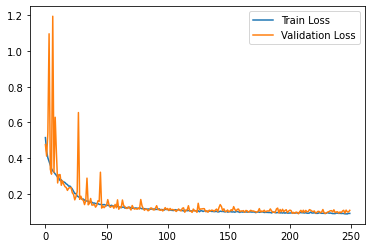

In [20]:
plt.plot(train_running_loss_history, label = 'Train Loss')
plt.plot(validation_running_loss_history, label = 'Validation Loss')
plt.legend()

In [21]:
model.eval()
X_train.size()

torch.Size([1, 1, 572, 572])

In [22]:
out = (y_pred + 0.5).int().float()

In [23]:
print(dice_index(y_train, out))
print(dice_loss(y_train, out))

tensor(0.8499, device='cuda:0')
tensor(0.1501, device='cuda:0')


In [24]:
# pig = plt.figure(figsize = (15, 6))

# a = pig.add_subplot(2, 3, 1)
# plt.imshow(im_converterX(X_train[0]))

# a = pig.add_subplot(2, 3, 2)
# plt.imshow(im_converterY(y_train[0]))

# a = pig.add_subplot(2, 3, 3)
# plt.imshow(im_converterY(out[0]))


# a = pig.add_subplot(2, 3, 4)
# plt.imshow(im_converterX(X_train[1]))

# a = pig.add_subplot(2, 3, 5)
# plt.imshow(im_converterY(y_train[1]))

# a = pig.add_subplot(2, 3, 6)
# plt.imshow(im_converterY(out[1]))

In [25]:
gg = dice_index(out, y_train)
print(gg)
print(dice_loss(out, y_train))

tensor(0.8499, device='cuda:0')
tensor(0.1501, device='cuda:0')


In [26]:
class HC18_test(Dataset):
    def __init__(self, root_dir, transformX = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'test_set_pixel_size.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        
    def __len__(self):
        return len(self.pixel_file)
    
    def __getitem__(self, index):
        imx_name = os.path.join(self.root_dir, 'test_set', self.pixel_file.iloc[index, 0])
        
        imx = Image.open(imx_name)
        
        f_name = self.pixel_file.iloc[index, 0]
        
        if self.transformX :
            imx = self.transformX(imx)
        
        sample = {'image': imx, 'f_name': f_name}
        return sample

In [27]:
test_data = HC18_test('', transformX = tx_X)

In [28]:
test_data

In [29]:
test_loader = DataLoader(dataset = test_data, batch_size = 2, shuffle = True)

In [30]:
test_loader

0 torch.Size([2, 1, 572, 572])


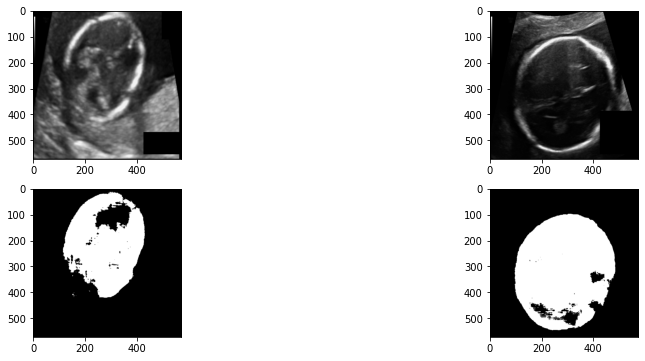

In [31]:
## Here we loop through our train_loader and see the images
## Looks good
fig = plt.figure(figsize = (15,6))
#model.to('cpu')
for ith_batch, sample_batched in enumerate(test_loader):
  
    X_test = sample_batched['image'].to('cuda')
    print(ith_batch, X_test.size())
    
    y_test = (model(X_test) + 0.5).int().float()
    
    
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(X_test[index]))
        
        ax  = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(y_test[index]))
    break

In [32]:
def avg_dice_index(dataloader):
  
    dice = 0.0
    model.eval()
    with torch.no_grad():
    
        for ith_batch, sample_batched in enumerate(dataloader):
  
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['annotation'].to('cuda')
            
            y_predict = (model(X_train) + 0.5).int().float()
            
            dice += dice_index(y_predict, y_train)
            
            
            
    avg_dice = dice / len(dataloader)
    return avg_dice.item()

In [33]:
avg_dice_index(validation_loader)    #### Dice index of validation data

0.9238138198852539

In [34]:
avg_dice_index(train_loader)        ### Dice index of training data

0.9224368333816528

In [35]:
test_loader = DataLoader(dataset = test_data, batch_size = 1, shuffle = True) # to write image files

## **Warning!!!**
### Your are about to write on drive

In [36]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((540, 800)),
        transforms.ToTensor()
        ])
    
with torch.no_grad():
      #model.eval()
      for ith_batch , sample in enumerate(test_loader):
        X_test = sample['image'].to('cuda')
        y_pred = (model(X_test) + 0.5).int().float().cpu()
#         print(335-ith_batch)
        
        file_names = sample['f_name']
        pankaj = transform(y_pred[0])
        #singh = transform(y_pred[1])
        torchvision.utils.save_image(pankaj , os.path.join('segmented', file_names[0]))
        #torchvision.utils.save_image(singh, os.path.join('/content/drive/My Drive/HC18/test_set', file_names[1].replace('.png','_Annotation.png')))
      print("Segmentation files written")
        
        

Segmentation files written


In [37]:
def fit_ellipse(im):    
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [len(contour) for contour in contours]
    ellipse = cv2.fitEllipse(contours[np.argmax(contour_sizes)])
    return ellipse

In [38]:
file_names = sorted([file for _,_,files in os.walk('segmented/') for file in files])

In [39]:
df_pixel_size = pd.read_csv('test_set_pixel_size.csv')
submission = {'filename': [], 'center_x_mm': [], 'center_y_mm': [], 'semi_axes_a_mm': [],
             'semi_axes_b_mm': [], 'angle_rad': [], 'Index': []}

file_names = sorted([file for _,_,files in os.walk('segmented/') for file in files])

for i, file_name in enumerate(file_names):
    im = cv2.imread('segmented/'+file_name)
   # file_name = file_name.replace('_Segmented', '')
    ellipse = fit_ellipse(im)
    im_mask = cv2.ellipse(np.zeros_like(im),ellipse,(255,255,255),-1)
    image_name = file_name.split('.')[0] + '_Annotation_fit.png'
    #cv2.imwrite('/content/drive/My Drive/HC18/test_set/'+image_name, im_mask)
    
    pixel_size = df_pixel_size.loc[df_pixel_size['filename'] == file_name, 'pixel size(mm)'].iloc[0]
    submission['filename'].extend([file_name])
    submission['Index'].extend([int(file_name.split('_')[0])])
    center_x,  center_y = ellipse[0]
    submission['center_x_mm'].extend([pixel_size*center_x])
    submission['center_y_mm'].extend([pixel_size*center_y])
    semi_axes_b, semi_axes_a = ellipse[1]
    if semi_axes_b > semi_axes_a:
        semi_axes_b = semi_axes_b + semi_axes_a
        semi_axes_a = semi_axes_b - semi_axes_a
        semi_axes_b -= semi_axes_a
    submission['semi_axes_a_mm'].extend([semi_axes_a*pixel_size/2])
    submission['semi_axes_b_mm'].extend([semi_axes_b*pixel_size/2])
    angle = ellipse[2]
    if angle < 90:
        angle += 90
    else:
        angle -= 90
    submission['angle_rad'].extend([np.deg2rad(angle)])
    
submission = pd.DataFrame(submission)
submission = submission[['filename', 'center_x_mm', 'center_y_mm', 
                         'semi_axes_a_mm', 'semi_axes_b_mm', 'angle_rad', 'Index']]    
submission = submission.sort_values(['Index'])
submission = submission.drop('Index', axis=1)
submission.to_csv("MFP-more-dropouts-250.csv", index=False)
print('Required .csv file generated')

Required .csv file generated


In [40]:
q = pd.read_csv('MFP_UNET_100.csv')  ## to check theck the generated csv

In [41]:
print('Length of csv file: ',len(q))

Length of csv file:  335


In [42]:
submission.head()

,filename,center_x_mm,center_y_mm,semi_axes_a_mm,semi_axes_b_mm,angle_rad
0,000_HC.png,93.748412,65.193993,53.712109,41.095947,3.115832
1,001_HC.png,29.643693,20.979579,12.414255,10.099775,2.992265
2,002_HC.png,60.978559,42.479207,38.717589,28.829894,0.009362
3,003_HC.png,34.266073,27.706023,28.155236,23.274399,3.118459
4,004_HC.png,80.571650,61.721990,54.354596,40.174511,3.112650


In [44]:
test_loader = DataLoader(dataset = test_data, batch_size = 2, shuffle = True)

In [ ]:
test